# **EDA + Data Cleaning on Condemned and Dead-End Properties Dataset**


**Collected Data From [Here](https://data.wprdc.org/dataset/condemned-properties/resource/0a963f26-eb4b-4325-bbbc-3ddf6a871410)**

### **Data Dictionary**
- **reserved__id:** (no description)
- **parcel_id:** The alphanumeric identifier for the Allegheny County parcel of land corresponding to the condemned property.
- **address:** The street address for the condemned property. In some cases the value is “No primary address specified.” In most of those cases, the corresponding record in the Allegheny County Property Assessments table has a house number of zero—meaning the parcel no longer exists (e.g., parcels were merged or split).
- **owner:** The name of the person or entity who owns the condemned property.
- **property_type:** Indicates whether the property is just condemned (“Condemned Property”) or one where the owner could not be contacted (“Dead-End Property”).
- **date:** The date that the property received its classification (e.g., “Condemned”).
- **latest_inspection_result:** The pass/fail result that the property received in its last inspection.
- **latest_inspection_score:** The numerical score from the last inspection. A value of 0 indicates the property passed; higher integers indicate greater severity of failure.
- **inspection_status:** Either “Active” or “Inactive,” indicating whether the property is under ongoing investigation.



### **Goal**
**Fix the notes for the dataset first**
1. Create solution for the duplicate #'s of **parcel_id**
- so no removing duplicates in the data cleaning stage

2. Correct the numerical range of the **latest_inspection_score**
- currently 0-62
- fix to 1-4 --> the information of the Inspection Score is defined in 1-4 range already [here](https://engage.pittsburghpa.gov/pli-demolition-engagement)

## **Initial Data Analysis**

In [39]:
# importing libraries
import pandas as pd               # data preprocessing
import numpy as np                # to work with #'s & arrays
import matplotlib.pyplot as plt   # more for graphing/visualizations

In [40]:
# bring in the file
csv_name = "deadend.csv"            # csv for condemned + dead-end properties
df = pd.read_csv(csv_name)
df.head(5)                          # sanity check - first 5

,_id,reserved__id,parcel_id,address,owner,property_type,date,latest_inspection_result,latest_inspection_score,inspection_status
0,330265,NaN,0081A00132000000,No primary address specified,MCCOY MARK JOEL & NICOLE HELENA (W),Condemned Property,2020-05-19T00:00:00,Fail,9.0,Inactive
1,330266,NaN,0174L00014000000,No primary address specified,BATTLE RAYNA,Condemned Property,2020-05-19T00:00:00,Fail,15.0,Inactive
2,330267,NaN,0175C00159000000,No primary address specified,WHEATON RALEIGH PIERRE,Condemned Property,2020-05-20T00:00:00,Fail,43.0,Inactive
3,330268,NaN,0049N00268000000,"321 37TH ST, Pittsburgh, 15201",NaN,Condemned Property,2020-05-21T00:00:00,Fail,21.0,Inactive
4,330269,NaN,0050M00310000000,"5452 BROAD ST, Pittsburgh, 15206",MONROE BRIAN,Condemned Property,2020-05-28T00:00:00,Fail,12.0,Inactive


In [41]:
df.shape                            # initial data shape

(4346, 10)

In [42]:
df.info()                           # null values/data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4346 entries, 0 to 4345
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   _id                       4346 non-null   int64  
 1   reserved__id              0 non-null      float64
 2   parcel_id                 4346 non-null   object 
 3   address                   4328 non-null   object 
 4   owner                     3658 non-null   object 
 5   property_type             4346 non-null   object 
 6   date                      4346 non-null   object 
 7   latest_inspection_result  3859 non-null   object 
 8   latest_inspection_score   3788 non-null   float64
 9   inspection_status         4344 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 339.7+ KB


### i. Drop Null Entries

In [43]:
# check # of null entries in each columns
print(df.isnull().sum())

_id                            0
reserved__id                4346
parcel_id                      0
address                       18
owner                        688
property_type                  0
date                           0
latest_inspection_result     487
latest_inspection_score      558
inspection_status              2
dtype: int64


**Note:**
- all *reserved_id* is Null
- 18 addresses is missing
- 688 owners are missing
- 487 latest inspection result is missing
- 558 latest inspection score is missing
- 2 inspection status is missing

First thing I'll try is removing all Null & checking the remaining # of entries.

In [44]:
# make copy of original df
clean_df = df.copy()

# drop reserved id column
clean_df = clean_df.drop(["reserved__id"], axis = 1)

# removing other null values
clean_df.dropna(inplace = True)         # in original df
clean_df.info()                         # check

<class 'pandas.core.frame.DataFrame'>
Index: 3190 entries, 0 to 4344
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   _id                       3190 non-null   int64  
 1   parcel_id                 3190 non-null   object 
 2   address                   3190 non-null   object 
 3   owner                     3190 non-null   object 
 4   property_type             3190 non-null   object 
 5   date                      3190 non-null   object 
 6   latest_inspection_result  3190 non-null   object 
 7   latest_inspection_score   3190 non-null   float64
 8   inspection_status         3190 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 249.2+ KB


In [45]:
clean_df.shape                          # check shape of changed

(3190, 9)

### ii. Convert **date** feature into 2 features (date + time)

Current **date** feature consists of date (YYYY-MM-DD) and time (HH:MM:SS), so I'm converting it into 2 separate features and into data type *datetime* for easier manipulation.

In [46]:
# split date - time where "T" exists
clean_df[['new_date', 'new_time']] = (clean_df['date'].str.split('T', expand = True))

# convert into data type datetime
clean_df['new_date'] = pd.to_datetime(clean_df['new_date']).dt.date
clean_df['new_time'] = pd.to_datetime(clean_df['new_time']).dt.time

# check
print(clean_df[['date', 'new_date', 'new_time']].head())

                  date    new_date  new_time
0  2020-05-19T00:00:00  2020-05-19  00:00:00
1  2020-05-19T00:00:00  2020-05-19  00:00:00
2  2020-05-20T00:00:00  2020-05-20  00:00:00
4  2020-05-28T00:00:00  2020-05-28  00:00:00
5  2020-05-29T00:00:00  2020-05-29  00:00:00


In [47]:
# get rid of the old column
clean_df.drop(columns = 'date', inplace = True)
clean_df.head(1)    # check it's gone

,_id,parcel_id,address,owner,property_type,latest_inspection_result,latest_inspection_score,inspection_status,new_date,new_time
0,330265,0081A00132000000,No primary address specified,MCCOY MARK JOEL & NICOLE HELENA (W),Condemned Property,Fail,9.0,Inactive,2020-05-19,00:00:00


## **Visualizations**

**I. Score dimensions (0-62)**

This will be converted into a 1-4 scale later.

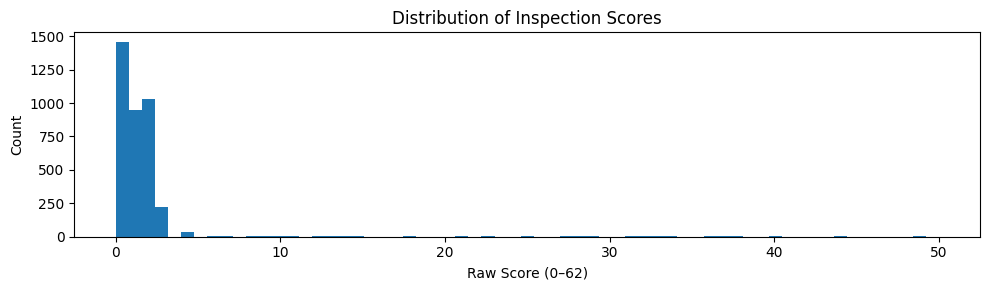

In [48]:
# defining the graph dimensions
plt.figure(figsize=(10,3))

# getting scores distribution
df['latest_inspection_score'].plot.hist(bins = 63)    # 62 intervals

# details of graph
plt.title('Distribution of Inspection Scores')
plt.xlabel('Raw Score (0–62)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**II. Owners Distribution (Top 10)**


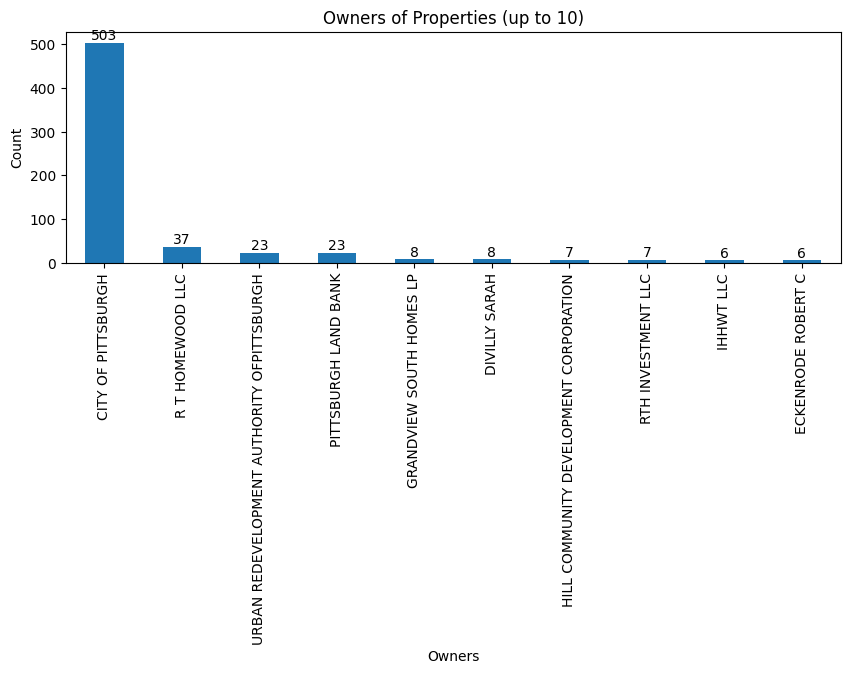

In [49]:
# owner counts
owner_c = clean_df['owner'].value_counts().nlargest(10)

# plot and label bars
owner_graph = owner_c.plot(kind='bar', figsize=(10,3))
owner_graph.bar_label(owner_graph.containers[0])        # add the count labels

# design / details
plt.title('Owners of Properties (up to 10)')
plt.xlabel("Owners")
plt.ylabel('Count')
plt.show()

**III. Pass or Fail Distribution**



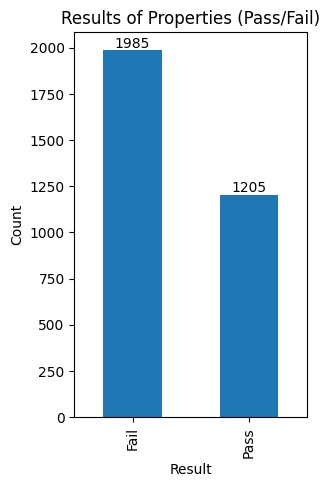

In [50]:
# results (pass/fail) counts
result_c = clean_df['latest_inspection_result'].value_counts()
# plot and label bars
result_graph = result_c.plot(kind='bar', figsize=(3,5))
result_graph.bar_label(result_graph.containers[0])        # add the count labels

# design / details
plt.title('Results of Properties (Pass/Fail)')
plt.xlabel("Result")
plt.ylabel('Count')
plt.show()

**IV. Condemned or Dead-End Distribution**


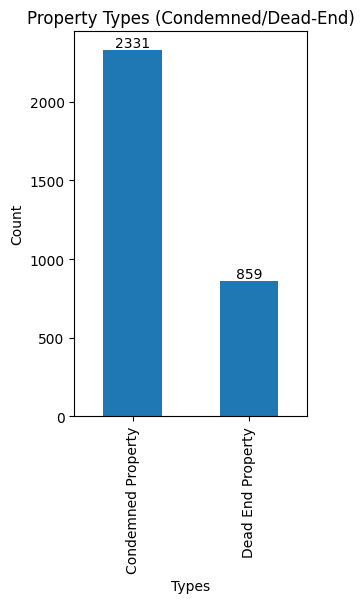

In [51]:
# property type counts
prop_c = clean_df['property_type'].value_counts()

# plot and label bars
proptype_graph = prop_c.plot(kind='bar', figsize=(3,5))
proptype_graph.bar_label(proptype_graph.containers[0])        # add the count labels

# design / details
plt.title('Property Types (Condemned/Dead-End)')
plt.xlabel("Types")
plt.ylabel('Count')
plt.show()

**V. Parcel ID Distribution (Top 10)**


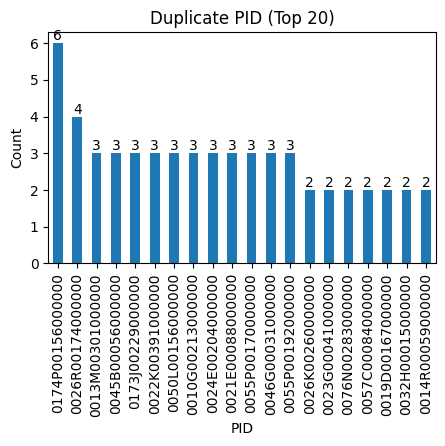

In [52]:
# parcel id counts
pid_c = clean_df['parcel_id'].value_counts().nlargest(20)

# plot and label bars
pid_graph = pid_c.plot(kind='bar', figsize=(5,3))
pid_graph.bar_label(pid_graph.containers[0])        # add the count labels

# design / details
plt.title('Duplicate PID (Top 20)')
plt.xlabel("PID")
plt.ylabel('Count')
plt.show()

**VI. Address Distribution (Top 10)**


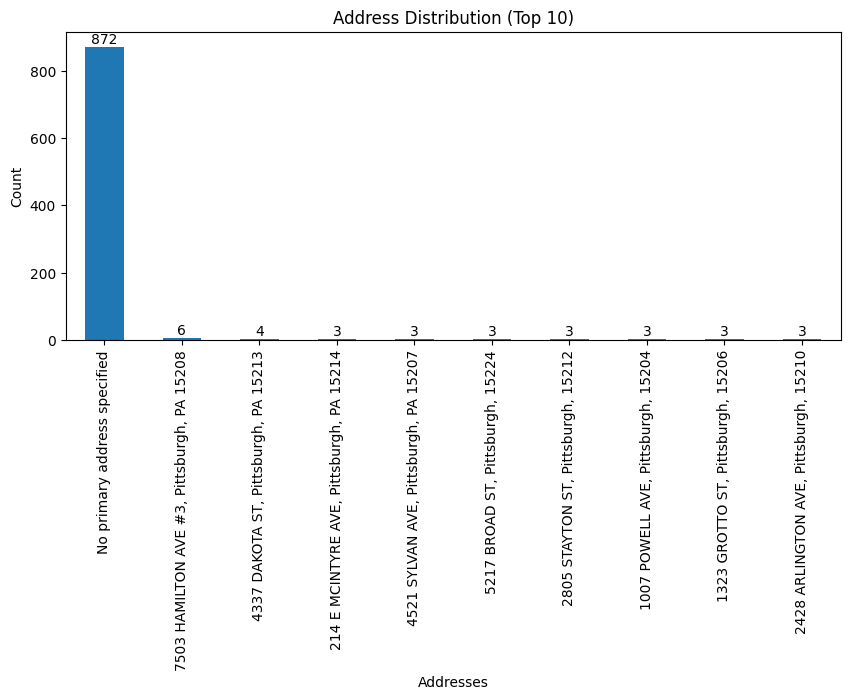

In [53]:
# address counts
add_c = clean_df['address'].value_counts().nlargest(10)

# plot and label bars
add_graph = add_c.plot(kind='bar', figsize=(10,4))
add_graph.bar_label(add_graph.containers[0])        # add the count labels

# design / details
plt.title('Address Distribution (Top 10)')
plt.xlabel("Addresses")
plt.ylabel('Count')
plt.show()

### **Insights**

**Score Dimensions**
*   Distribution of the initial scores range mostly around 0-5.

**Owners Distribution**
*   503 properties (~15.8% of properties) are owned by the City of Pittsburgh

**Pass or Fail Distribution**
*   ~62.2% of properties failed the latest inspections (1985 properties)
*  ~37.8% of properties passed the latest inspections (1205 properties)

**Condemned or Dead-End Distributions**
*  ~73.1% of properties are condemned properties
*  ~26.9% of properties are dead-end properties

**Parcel ID Distribution**
*  Some unique parcel ID's have more than 1 entry, showing duplicate parcel id issues

**Address Distribution**
*  ~27.3% of the properties (872 properties) have no valid parcel ID



# **Data Cleaning**

*   Convert **latest_inspection_score** range from 0-62 to **1-4**
*   Remove **parcel_id** duplicates



## **Adjust Score Range**

In [54]:
'''Helper Function to adjust score to 1-4 range:
  - Score 1: 0-16
  - Score 2: 16-32
  - Score 3: 32 - 47
  - Score 4: 47 - 63 '''

def score_adjust(x):
    if pd.isna(x):        # make sure not empty
        return pd.NA
    if x < 16:
        return 1
    elif x < 32:
        return 2
    elif x < 47:
        return 3
    elif x < 63:
        return 4

# apply the function
clean_df['score'] = clean_df['latest_inspection_score'].apply(score_adjust)
clean_df.head(5)          # check

,_id,parcel_id,address,owner,property_type,latest_inspection_result,latest_inspection_score,inspection_status,new_date,new_time,score
0,330265,0081A00132000000,No primary address specified,MCCOY MARK JOEL & NICOLE HELENA (W),Condemned Property,Fail,9.0,Inactive,2020-05-19,00:00:00,1
1,330266,0174L00014000000,No primary address specified,BATTLE RAYNA,Condemned Property,Fail,15.0,Inactive,2020-05-19,00:00:00,1
2,330267,0175C00159000000,No primary address specified,WHEATON RALEIGH PIERRE,Condemned Property,Fail,43.0,Inactive,2020-05-20,00:00:00,3
4,330269,0050M00310000000,"5452 BROAD ST, Pittsburgh, 15206",MONROE BRIAN,Condemned Property,Fail,12.0,Inactive,2020-05-28,00:00:00,1
5,330270,0050L00156000000,"5217 BROAD ST, Pittsburgh, 15224",S&SF LLC,Condemned Property,Fail,11.0,Inactive,2020-05-29,00:00:00,1


In [55]:
# written visualization
print(f"\n{clean_df['score'].value_counts().sort_index()}")


score
1    3137
2      23
3      27
4       3
Name: count, dtype: int64


✅ Fixed the score range --> See if this helped with any **parcel_id** duplicate issues.

### **Difference in Duplicate PID's with new score**

In [56]:
'''This is before applying the new score system'''
# count of duplicate parcel_id's
pid_count = clean_df['parcel_id'].value_counts()
dup_pid = pid_count[pid_count > 1].index.tolist() # filter to pids with more thn 1 entry to list

print("This is BEFORE dropping latest_inspection_score:")
print(f"\nList of Duplicate PID's: {dup_pid}\nNumber of Duplicate PID's: {len(dup_pid)}")

'''This is after applying the new score system'''
# drop the old score
clean_df.drop(columns = ['latest_inspection_score'], inplace = True)

# drop duplicates based on parcel_id & score, keep first - order doesn't matter
clean_df.drop_duplicates(subset = ['parcel_id', 'score'], keep = 'first', inplace = True)

# recalculate duplicate parcel_id's
new_pid_count = clean_df['parcel_id'].value_counts()
new_dup_pid = new_pid_count[new_pid_count > 1].index.tolist()

print("This is AFTER dropping latest_inspection_score:")
print(f"\nList of Duplicate PID's: {new_dup_pid}\nNumber of Duplicate PID's: {len(new_dup_pid)}")


This is BEFORE dropping latest_inspection_score:

List of Duplicate PID's: ['0174P00156000000', '0026R00174000000', '0013M00301000000', '0045B00056000000', '0173J00229000000', '0022K00391000000', '0050L00156000000', '0010G00213000000', '0024E00204000000', '0021E00088000000', '0055P00170000000', '0046G00031000000', '0055P00192000000', '0026K00260000000', '0023G00041000000', '0076N00283000000', '0057C00084000000', '0019D00167000000', '0032H00015000000', '0014R00059000000', '0015G00169000000', '0014F00357000000', '0022H00105000000', '0047N00303000000', '0174K00117000001', '0046A00044000000', '0041D00038000000', '0045N00181000000', '0172N00060000000', '0010G00233000000', '0047N00230000000', '0022E00280000000', '0045B00227000000', '0010K00149000C00', '0023H00275000000', '0015G00202000000', '0033B00338000000', '0173C00059000000', '0015R00157000000', '0022F00063000A00', '0077P00171000000', '0024K00003000000', '0087K00274000000', '0060B00087000000', '0014P00093000000', '0231L00240000000', '003

Now we have 9 duplicate **parcel_id** that is duplicate, but have differing scores.

## **Clean Duplicate Parcel ID**

**new_dup_pid** has a list of the remaining duplicate pid's.

View the details of the duplicate entries below:

In [57]:
# for each pid in the list
for pid in new_dup_pid:
    # row of the duplicate pid
    grp = clean_df[clean_df['parcel_id'] == pid]
    print(f"Parcel ID: {pid}")
    # print the repeating id, date, time, and score
    print(grp[['parcel_id','new_date','new_time','score']].to_string(index=False))
    print()

Parcel ID: 0015M00220000000
       parcel_id   new_date new_time  score
0015M00220000000 2020-11-19 00:00:00      2
0015M00220000000 2020-06-25 00:00:00      1

Parcel ID: 0174K00324000000
       parcel_id   new_date new_time  score
0174K00324000000 2020-07-30 00:00:00      2
0174K00324000000 2022-05-16 00:00:00      1

Parcel ID: 0014F00067000000
       parcel_id   new_date new_time  score
0014F00067000000 2020-07-15 00:00:00      1
0014F00067000000 2020-12-23 00:00:00      3

Parcel ID: 0094N00037000000
       parcel_id   new_date new_time  score
0094N00037000000 2020-06-16 00:00:00      2
0094N00037000000 2020-12-03 00:00:00      1

Parcel ID: 0015G00098000000
       parcel_id   new_date new_time  score
0015G00098000000 2020-06-11 00:00:00      1
0015G00098000000 2020-11-19 00:00:00      3

Parcel ID: 0010N00307000000
       parcel_id   new_date new_time  score
0010N00307000000 2020-08-27 00:00:00      3
0010N00307000000 2021-03-29 00:00:00      1

Parcel ID: 0022F00119000000
      

In [58]:
'''
Removing Duplicate PID.
Keep:
  - Latest Entry
  - If date is same, Latest Time
  - If date and time is same, Highest Score.
'''
def remove_duplicates(data):      # data would be the df
    # sort values in terms of each feature then drop duplicates
    return (data.sort_values(['parcel_id','new_date', 'new_time', 'score']).drop_duplicates('parcel_id', keep='last').reset_index(drop = True))

# new df with applied function
no_dupe_df = remove_duplicates(clean_df)

# recheck the same list of 9 duplicate pids
for pid in new_dup_pid:
    grp = no_dupe_df[no_dupe_df['parcel_id'] == pid]
    print(f"Parcel ID: {pid}")
    print(grp[['parcel_id','new_date','new_time','score']].to_string(index=False))
    print()

Parcel ID: 0015M00220000000
       parcel_id   new_date new_time  score
0015M00220000000 2020-11-19 00:00:00      2

Parcel ID: 0174K00324000000
       parcel_id   new_date new_time  score
0174K00324000000 2022-05-16 00:00:00      1

Parcel ID: 0014F00067000000
       parcel_id   new_date new_time  score
0014F00067000000 2020-12-23 00:00:00      3

Parcel ID: 0094N00037000000
       parcel_id   new_date new_time  score
0094N00037000000 2020-12-03 00:00:00      1

Parcel ID: 0015G00098000000
       parcel_id   new_date new_time  score
0015G00098000000 2020-11-19 00:00:00      3

Parcel ID: 0010N00307000000
       parcel_id   new_date new_time  score
0010N00307000000 2021-03-29 00:00:00      1

Parcel ID: 0022F00119000000
       parcel_id   new_date new_time  score
0022F00119000000 2020-09-10 00:00:00      4

Parcel ID: 0043S00018000000
       parcel_id   new_date new_time  score
0043S00018000000 2022-07-27 00:00:00      1

Parcel ID: 0075M00337000000
       parcel_id   new_date new_time

In [59]:
# count of duplicate parcel_id's
last_pid_count = no_dupe_df['parcel_id'].value_counts()
last_dup_pid = last_pid_count[last_pid_count > 1].index.tolist() # filter to pids with more thn 1 entry to list

print("This is after cleaning scores + pid's:")
print(f"\nList of Duplicate PID's: {last_dup_pid}\nNumber of Duplicate PID's: {len(last_dup_pid)}")


This is after cleaning scores + pid's:

List of Duplicate PID's: []
Number of Duplicate PID's: 0


In [77]:
no_dupe_df

,_id,parcel_id,address,owner,property_type,latest_inspection_result,inspection_status,new_date,new_time,score
0,332079,0001G00106000000,"108 MARKET ST, Pittsburgh, PA 15222",BOULEVARD & MARKET LLC,Condemned Property,Pass,Active,2023-11-29,00:00:00,1
1,332078,0001G00107000000,No primary address specified,TROY DEVELOPMENT ASSOCIATES LP,Condemned Property,Pass,Active,2023-11-29,00:00:00,1
2,332077,0001G00109000000,No primary address specified,TROY DEVELOPMENT ASSOCIATES LP,Condemned Property,Pass,Active,2023-11-29,00:00:00,1
3,332076,0001H00046000000,"209 1ST AVE, Pittsburgh, 15222",TROY DEVELOPMENT ASSOCIATES,Condemned Property,Pass,Active,2023-11-29,00:00:00,1
4,332402,0001H00216000000,"5 MARKET SQ, Pittsburgh, 15222",PITTSBURGH REAL ESTATE COMPANY LLC,Condemned Property,Fail,Active,2020-06-04,00:00:00,1
...,...,...,...,...,...,...,...,...,...,...
2797,333598,0232B00161000000,"1721 CRESTLINE ST, Pittsburgh, 15221",ATL HOLDINGS LLC,Condemned Property,Fail,Active,2020-08-27,00:00:00,1
2798,333597,0232B00290000000,"619 DORNBUSH ST, Pittsburgh, PA 15221",BROWN FRANCES R,Condemned Property,Fail,Active,2020-08-27,00:00:00,1
2799,334416,0232C00004000000,"2053 FRANKELLA AVE, Pittsburgh, 15221",CITY OF PITTSBURGH,Condemned Property,Fail,Active,2020-08-31,00:00:00,1
2800,332555,0232F00158000000,"1719 CRESTLINE ST, Pittsburgh, 15221",HUC ONE LLC,Condemned Property,Fail,Inactive,2020-08-27,00:00:00,1


✅ Fixed the duplicate pid's.

- reduced 371 duplicate pid's to 9 duplicate pid's from implementing the new scoring system
- reduced overall 388 entries by implmenting new score + removing duplicate helper function
- ended up with 2,802 rows with 10 columns

## **New Visualizations**

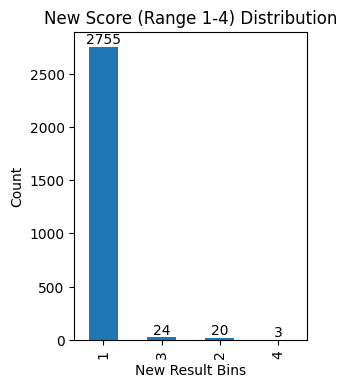

In [60]:
# score counts
new_score_c = no_dupe_df['score'].value_counts()
# plot and label bars
new_score_graph = new_score_c.plot(kind='bar', figsize=(3,4))
new_score_graph.bar_label(new_score_graph.containers[0])        # add the count labels

# design / details
plt.title('New Score (Range 1-4) Distribution')
plt.xlabel("New Result Bins")
plt.ylabel('Count')
plt.show()

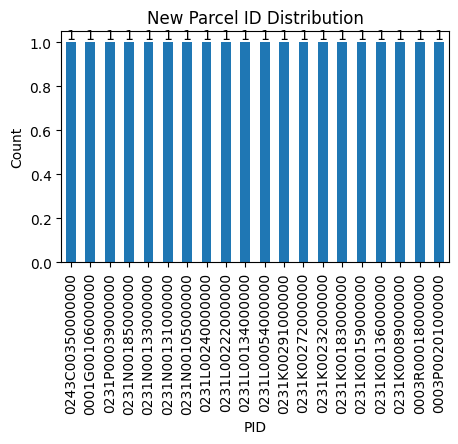

In [61]:
# parcel id counts
new_pid_c = no_dupe_df['parcel_id'].value_counts().nlargest(20)

# plot and label bars
new_pid_graph = new_pid_c.plot(kind='bar', figsize=(5,3))
new_pid_graph.bar_label(new_pid_graph.containers[0])        # add the count labels

# design / details
plt.title('New Parcel ID Distribution')
plt.xlabel("PID")
plt.ylabel('Count')
plt.show()

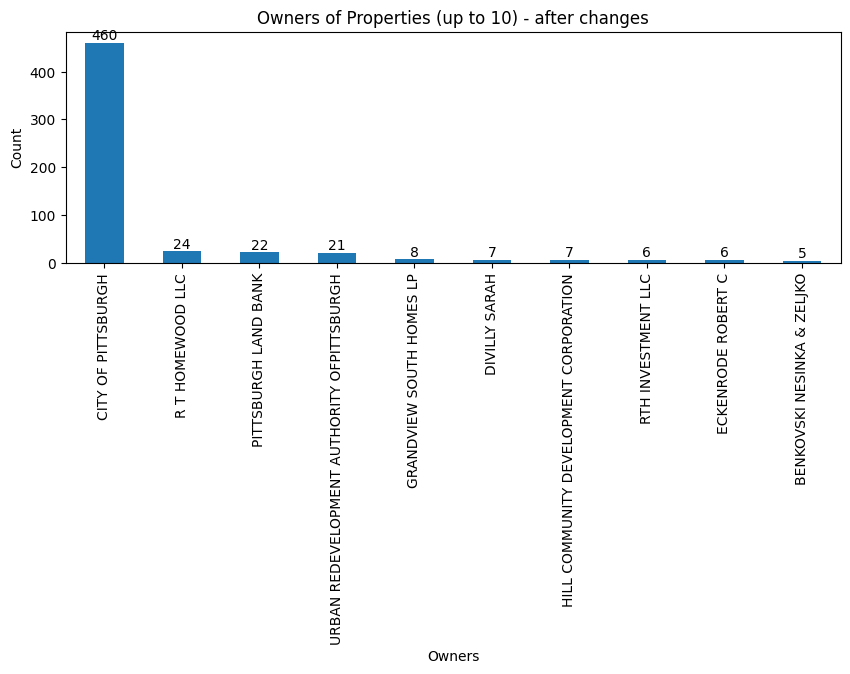

In [62]:
# owner counts
new_owner_c = no_dupe_df['owner'].value_counts().nlargest(10)

# plot and label bars
new_owner_graph = new_owner_c.plot(kind='bar', figsize=(10,3))
new_owner_graph.bar_label(new_owner_graph.containers[0])        # add the count labels

# design / details
plt.title('Owners of Properties (up to 10) - after changes')
plt.xlabel("Owners")
plt.ylabel('Count')
plt.show()

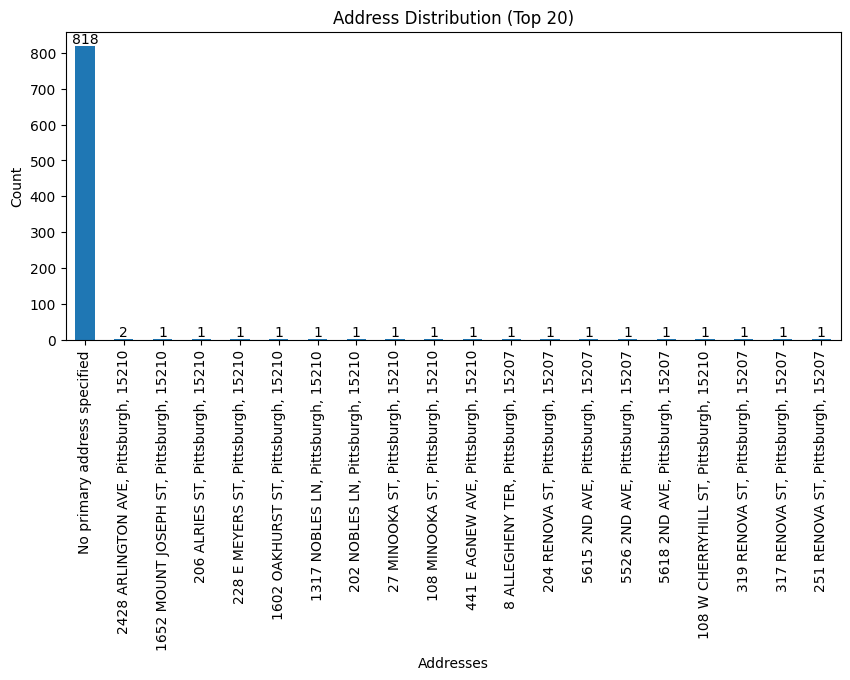

In [63]:
# address counts
add_counts = no_dupe_df['address'].value_counts().nlargest(20)
# plot and label bars
add_graph = add_counts.plot(kind='bar', figsize=(10,4))
add_graph.bar_label(add_graph.containers[0])        # add the count labels
# design / details
plt.title('Address Distribution (Top 20)')
plt.xlabel("Addresses")
plt.ylabel('Count')
plt.show()

# **More Data Exploration: Condemned Properties**

In [64]:
no_dupe_df.shape

(2802, 10)

In [65]:
# creating condemned property df
condemned_prop_df = no_dupe_df[(no_dupe_df['property_type'] == 'Condemned Property')]
condemned_prop_df.shape

(1991, 10)

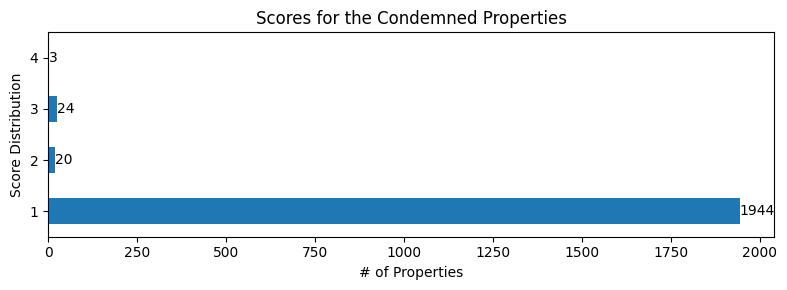

In [66]:
'''scores for condemned'''
# counts of condemned properties in each score label
condemned_score_counts = condemned_prop_df['score'].value_counts().sort_index()
# plot horizontal bars and capture the Axes
condemned_score_plot = condemned_score_counts.plot.barh(figsize=(8, 3))
# annotate each bar with its count
condemned_score_plot.bar_label(condemned_score_plot.containers[0])
# titles and labels
plt.title('Scores for the Condemned Properties')
plt.xlabel('# of Properties')
plt.ylabel('Score Distribution')
plt.tight_layout()
plt.show()

In [78]:
# records with score = 4
score4 = condemned_prop_df[condemned_prop_df['score'] == 4]
score4

,_id,parcel_id,address,owner,property_type,latest_inspection_result,inspection_status,new_date,new_time,score
807,330336,0022F00119000000,No primary address specified,CITY OF PITTSBURGH,Condemned Property,Fail,Inactive,2020-09-10,00:00:00,4
1537,330329,0047E00052000000,No primary address specified,GILL JOHN,Condemned Property,Fail,Inactive,2020-09-04,00:00:00,4
2791,330285,0232A00021000000,No primary address specified,GARDNER LUELLA B,Condemned Property,Fail,Inactive,2020-07-10,00:00:00,4


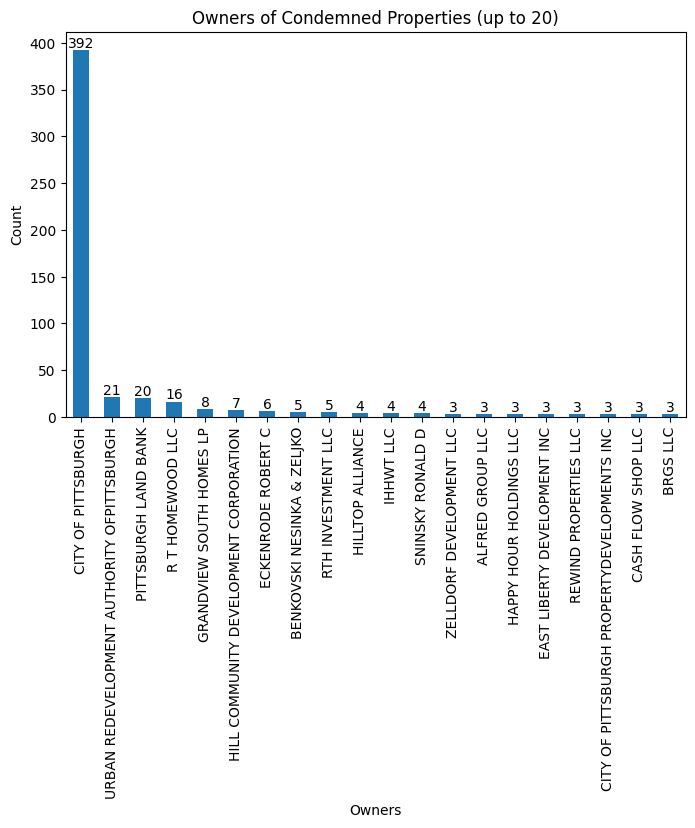

In [67]:
'''owner for condemned'''
# owner counts
owner_condemned_counts = condemned_prop_df['owner'].value_counts().nlargest(20)
# plot and label bars
owner_condemned_graph = owner_condemned_counts.plot(kind='bar', figsize=(8, 5))
owner_condemned_graph.bar_label(owner_condemned_graph.containers[0])    # add the count labels
# design / details
plt.title('Owners of Condemned Properties (up to 20)')
plt.xlabel("Owners")
plt.ylabel('Count')
plt.show()

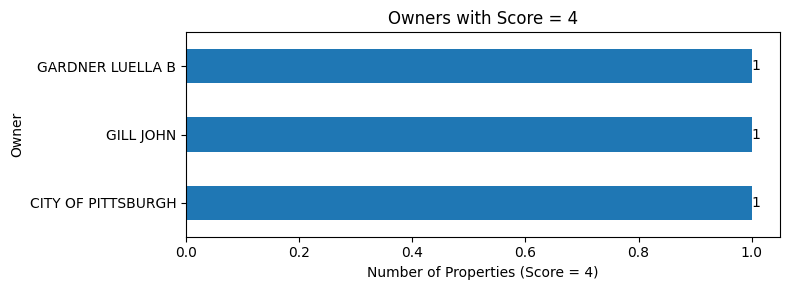

In [68]:
'''owners for the score 4 properties'''
# records with score = 4
score4 = condemned_prop_df[condemned_prop_df['score'] == 4]
# count occurrences per owner
owner_counts = score4['owner'].value_counts()
# horizontal bar chart
score4_owners = owner_counts.plot(kind='barh', figsize=(8, 3))
score4_owners.bar_label(score4_owners.containers[0])
# labels and title
plt.title('Owners with Score = 4')
plt.xlabel('Number of Properties (Score = 4)')
plt.ylabel('Owner')
plt.tight_layout()
plt.show()

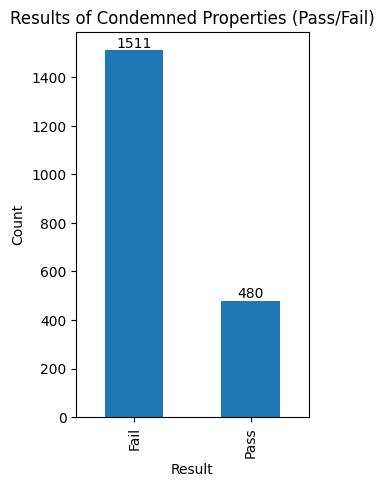

In [69]:
'''pass/fail for condemned'''
# pass/fail
result_condemned_counts = condemned_prop_df['latest_inspection_result'].value_counts()
# plot and label bars
result_condemned_graph = result_condemned_counts.plot(kind='bar', figsize=(3,5))
result_condemned_graph.bar_label(result_condemned_graph.containers[0])    # add count labels
# design / details
plt.title('Results of Condemned Properties (Pass/Fail)')
plt.xlabel("Result")
plt.ylabel('Count')
plt.show()

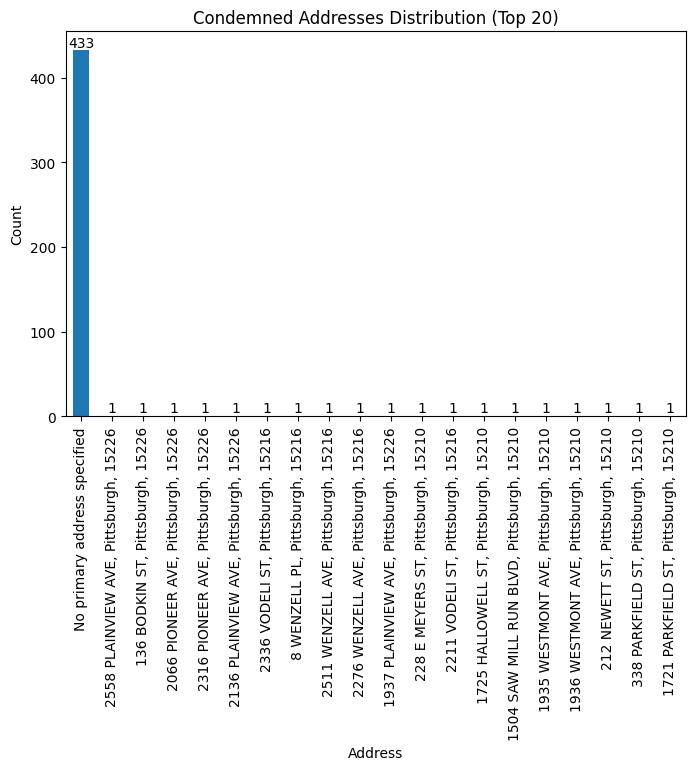

In [70]:
'''addresses for condemned'''
# addresses
condemned_add = condemned_prop_df['address'].value_counts().nlargest(20)
# plot and label bars
condemned_add_graph = condemned_add.plot(kind='bar', figsize=(8,5))
condemned_add_graph.bar_label(condemned_add_graph.containers[0])    # add count labels
# design / details
plt.title('Condemned Addresses Distribution (Top 20)')
plt.xlabel("Address")
plt.ylabel('Count')
plt.show()

# **More Data Exploration: Dead-End Properties**

In [71]:
# creating deadend property df
deadend_prop_df = no_dupe_df[(no_dupe_df['property_type'] == 'Dead End Property')]
deadend_prop_df.shape

(811, 10)

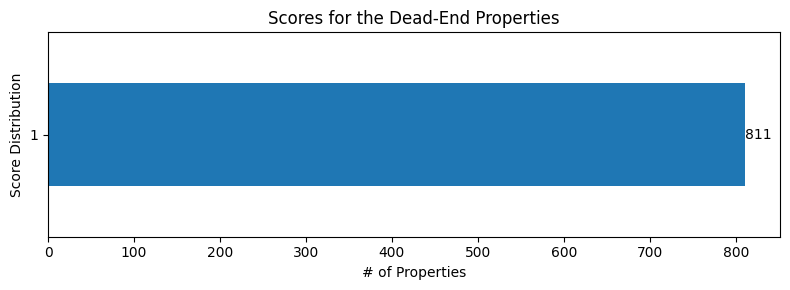

In [72]:
'''scores for deadend'''
# counts of condemned properties in each score label
deadend_score_counts = deadend_prop_df['score'].value_counts().sort_index()
# plot horizontal bars and capture the Axes
deadend_score_plot = deadend_score_counts.plot.barh(figsize=(8, 3))
# annotate each bar with its count
deadend_score_plot.bar_label(deadend_score_plot.containers[0])
# titles and labels
plt.title('Scores for the Dead-End Properties')
plt.xlabel('# of Properties')
plt.ylabel('Score Distribution')
plt.tight_layout()
plt.show()

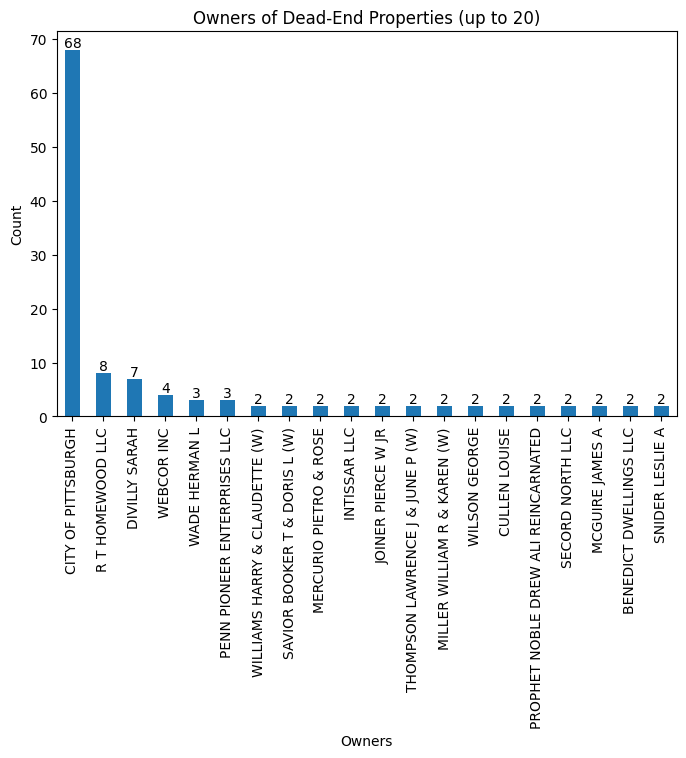

In [73]:
'''owner for deadend'''
# owner counts
owner_deadend_counts = deadend_prop_df['owner'].value_counts().nlargest(20)
# plot and label bars
owner_deadend_graph = owner_deadend_counts.plot(kind='bar', figsize=(8,5))
owner_deadend_graph.bar_label(owner_deadend_graph.containers[0])    # add the count labels
# design / details
plt.title('Owners of Dead-End Properties (up to 20)')
plt.xlabel("Owners")
plt.ylabel('Count')
plt.show()

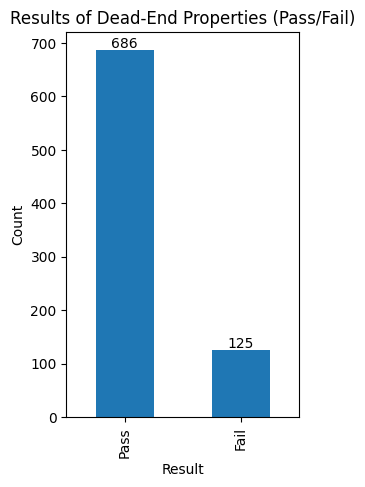

In [74]:
'''pass/fail for deadend'''
# pass/fail
result_deadend_counts = deadend_prop_df['latest_inspection_result'].value_counts()
# plot and label bars
result_deadend_graph = result_deadend_counts.plot(kind='bar', figsize=(3,5))
result_deadend_graph.bar_label(result_deadend_graph.containers[0])    # add count labels
# design / details
plt.title('Results of Dead-End Properties (Pass/Fail)')
plt.xlabel("Result")
plt.ylabel('Count')
plt.show()

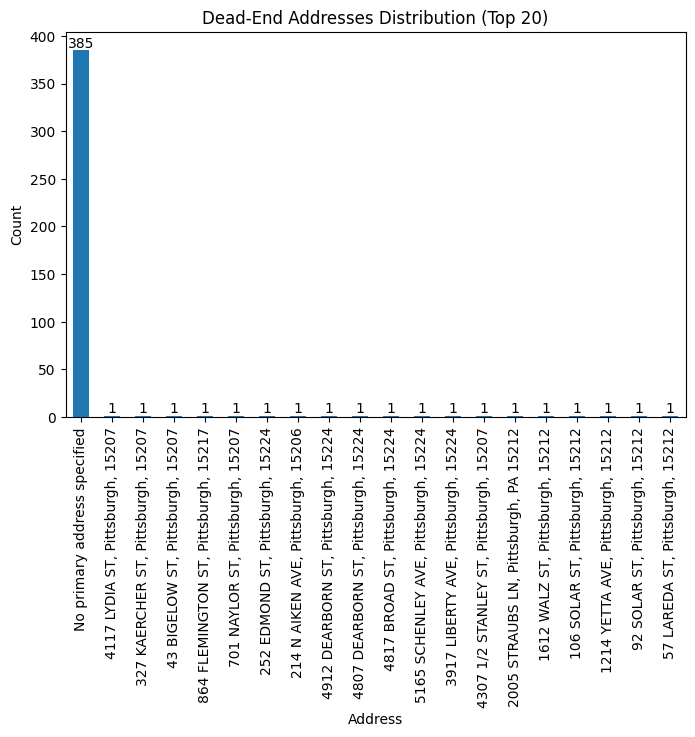

In [75]:
'''addresses for deadend'''
# addresses
deadend_add = deadend_prop_df['address'].value_counts().nlargest(20)
# plot and label bars
deadend_add_graph = deadend_add.plot(kind='bar', figsize=(8,5))
deadend_add_graph.bar_label(deadend_add_graph.containers[0])    # add count labels
# design / details
plt.title('Dead-End Addresses Distribution (Top 20)')
plt.xlabel("Address")
plt.ylabel('Count')
plt.show()

# **Overall Insights**

**Condemned or Dead-End**
- Approximately 79.2% of Properties are Condemned
- Approximately 20.8% of Properties are Dead-End

**Fail Inspection**
- Approximately 79.3% of Condemned Properties Fail Inspection.
- Approximately 10.6% of Dead-End Properties Fail Inspection.

**Scores Evaluation**
*   All Dead-End Properties having a score of 1 show that they are structurally intact with no immediate observable danger. **[Source](https://engage.pittsburghpa.gov/pli-demolition-engagement)**
*   Condemned Properties scores range from 1-4, with 4 being imminently dangerous, these can be the properties/areas the city prioritizes.


**Score 4 Properties**
*   The 3 owners of the 3 Score 4 Properties are: City of Pittsburgh, Gill John, and Gardner Luella B.
*   By Identifying their Addresses with the cleaned dataset, we could prioritize these high-risk properties to obtain private demolition permit or a building permit to repair.

**Addresses**
*   Most addresses in the dataset is listed as "No primary address specified".
*   This will have to be filled in to figure out which areas should be prioritized first.

## Next Steps
Next Steps would be to concatenate this dataset with other datasets to fill in the addresses if possible.



### **Saved CSV Info:**

**no_dupe_df.csv** --> New date and time, New scores, No duplicate parcel ID's.


In [76]:
no_dupe_df.to_csv('no_dupe_df.csv', index = False)